In [1]:
#This notebook trains a single RNN using all ten sessions of data and a specified train/test partition
#(can be 'HeldOutBlocks' or 'HeldOutTrials'). The RNN training process is launched in a separate python kernel. 
#This notebook then monitors training progress in real-time by loading data files produced by the RNN trainer
#and plotting them here, so you can watch how it learns over time. 

In [2]:
import numpy as np
import scipy.io
import scipy.ndimage.filters
import os
import matplotlib
import matplotlib.pyplot as plt
import pickle
from datetime import datetime
from charSeqRNN import charSeqRNN, getDefaultRNNArgs
from characterDefinitions import getHandwritingCharacterDefinitions
from characterDefinitionsOrig import getHandwritingCharacterDefinitionsOrig
import tensorflow as tf
#import mat73
#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)


#point this towards the top level dataset directory
rootDir = os.path.expanduser('.') + '/handwritingBCIData/'

#train an RNN using data from these specified sessions
dataDirs = ['t5.2019.05.08','t5.2019.11.25','t5.2019.12.09','t5.2019.12.11','t5.2019.12.18',
            't5.2019.12.20','t5.2020.01.06','t5.2020.01.08','t5.2020.01.13','t5.2020.01.15',
            'IamOnline1','IamOnline2','IamOnline3',
            'IamOnline5','IamOnline6','IamOnline7','IamOnline8','IamOnline9','IamOnline10','IamOnline11','IamOnline12']
dataDirs = ['t5.2019.05.08','t5.2019.11.25','t5.2019.12.09','t5.2019.12.11','t5.2019.12.18',
            't5.2019.12.20','t5.2020.01.06','t5.2020.01.08','t5.2020.01.13','t5.2020.01.15',
            'IamOnline1','IamOnline2','IamOnline3',
            'IamOnline5','IamOnline6']

dataDirs = ['t5.2019.05.08','t5.2019.11.25','t5.2019.12.09','t5.2019.12.11','t5.2019.12.18',
            't5.2019.12.20','t5.2020.01.06','t5.2020.01.08','t5.2020.01.13','t5.2020.01.15', 
            'IamOnline1','IamOnline2','IamOnline3','IamOnline5']
dataDirs = [ 
            'IamOnline1','IamOnline2','IamOnline3','IamOnline5']
dataDirs = ['t5.2019.05.08','t5.2019.11.25','t5.2019.12.09','t5.2019.12.11','t5.2019.12.18',
            't5.2019.12.20','t5.2020.01.06','t5.2020.01.08','t5.2020.01.13','t5.2020.01.15', 
            'IamOnline1','IamOnline2','IamOnline5']
dataDirs = [ 'IamOnline1','IamOnline2']

#use this train/test partition 
cvPart = 'HeldOutTrials'

#name of the directory where this RNN run will be saved
rnnOutputDir = cvPart

os.environ["CUDA_VISIBLE_DEVICES"]='0' # Nithin change, added this line

#all RNN runs are saved in 'Step4_RNNTraining'
if not os.path.isdir(rootDir + 'RNNTrainingSteps/Step4_RNNTraining'):
    os.mkdir(rootDir + 'RNNTrainingSteps/Step4_RNNTraining')
    


In [3]:
#We will use the default arguments specified here
args = getDefaultRNNArgs()  
    
#Configure the arguments for a multi-day RNN (that will have a unique input layer for each day)

for x in range(len(dataDirs)):
    
      #defines the list of all 31 characters and what to call them  
    if "IamOnline" in dataDirs[x]:
      charDef = getHandwritingCharacterDefinitions()
    else:
      charDef = getHandwritingCharacterDefinitionsOrig() 
    
    if "IamOnline" in dataDirs[x]:
  #    sentenceDat = scipy.io.loadmat(rootDir+'Datasets/'+'t5.2019.05.08'+'/sentences.mat')# Template is required
      sentence1 = scipy.io.loadmat(rootDir+'Datasets/'+dataDirs[x]+'/'+'neuralCubeStruct_IamOnline.mat')
      sentenceDat = scipy.io.loadmat(rootDir+'Datasets/'+dataDirs[x]+'/'+'neuralCubeStruct_IamOnline.mat')
  #    sentenceDat['neuralActivityCube'] = sentence1['neuralActivityCube']
  #    sentenceDat['intendedText'] = sentence1['intendedText']
  #    sentenceDat['sentencePrompt'] = sentence1['sentencePrompt']
  #    sentenceDat['numTimeBinsPerSentence'] = sentence1['numTimeBinsPerSentence']
      sentenceDat['blockList'] = []
#      sentenceDat['trainPartitionIdx'] = sentence1['trainPartitionIdx']
#      sentenceDat['testPartitionIdx'] = sentence1['testPartitionIdx'] 
    else:
      sentenceDat = scipy.io.loadmat(rootDir+'Datasets/'+dataDirs[x]+'/sentences.mat')
    
    trainTest = scipy.io.loadmat(rootDir+'RNNTrainingSteps/trainTestPartitions_'+cvPart+'.mat')
    
    if "IamOnline" in dataDirs[x]:
      trainTest[dataDirs[x]+'_train'] = sentence1['trainPartitionIdx']
#       trainTest[dataDirs[x]+'_train'] = trainTest['t5.2019.05.08_train']
      alist = sentence1['trainPartitionIdx'] 
      indices=np.argwhere(np.isin(alist,trainTest['t5.2019.05.08_test'])) # Delete test indices from the train
      alist=np.delete(alist,indices)
  #    trainTest[dataDirs[x]+'_train'] = trainTest['t5.2019.05.08_train']
  #    trainTest[dataDirs[x]+'_test'] = trainTest['t5.2019.05.08_test']
      trainTest[dataDirs[x]+'_train'] = sentence1['trainPartitionIdx1']
      trainTest[dataDirs[x]+'_test'] = sentence1['testPartitionIdx1']
   #   trainTest[dataDirs[x]+'_train'] = np.array([1, 2, 15,18,5,  6,  8,  9, 11, 13, 16 ,20, 21, 22, 23 ,24, 25, 26, 27, 28,10 ,12, 14 ,17 ,19])
    #  trainTest[dataDirs[x]+'_test'] = np.array([0, 3, 7, 4])
#       trainTest[dataDirs[x]+'_test'] = sentence1['testPartitionIdx']
    else:
      print("Before", trainTest[dataDirs[x]+'_train']) 
    #  trtest = np.concatenate(trainTest[dataDirs[x]+'_train'] , trainTest[dataDirs[x]+'_test'])
      maxtrainset = np.array([[0, 5, 8, 10, 12, 15, 17, 20, 22, 25, 30, 32, 35,  40, 45, 50]])
      testset = np.array([[3, 7, 14, 19, 23, 28, 31, 37, 43, 48]])   
#      trainset =  np.array([[0, 10]]) # CASE 1
      trainset =  np.array([[0, 10, 20, 35]]) # CASE 2
#      trainset =  np.array([[0, 5, 10, 15, 20, 25, 30, 35]]) # CASE 3
#      trainset =  np.array([[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 12]]) # CASE 4
#      trainset = np.array([[0, 5, 8, 10, 12, 15, 17, 20, 22, 25, 30, 32, 35,  40]]) # CASE 4a
#      trainset = np.array([[0, 5, 8, 10, 12, 15, 17, 20, 22, 25, 30, 32, 35,  40, 45, 50]]) # CASE 5
      trainTest[dataDirs[x]+'_train'] = trainset
      trainTest[dataDirs[x]+'_test'] = testset
        
#      tr = trainTest[dataDirs[x]+'_train']
#      trainTest[dataDirs[x]+'_train']= np.delete(tr, np.arange(0, tr.size, 2))
#      tr = trainTest[dataDirs[x]+'_train']
 #     trainTest[dataDirs[x]+'_train']= np.delete(tr, np.arange(0, tr.size, 2))
#      tr = trainTest[dataDirs[x]+'_train']
#      trainTest[dataDirs[x]+'_train']= np.delete(tr, np.arange(0, tr.size, 2))
#      tr = trainTest[dataDirs[x]+'_train']
#      trainTest[dataDirs[x]+'_train']= np.delete(tr, np.arange(0, tr.size, 2))  
  #    trainTest[dataDirs[x]+'_train'] = np.array([1, 5, 8, 10, 12, 15, 17, 20, 22, 25, 30, 32, 35,  40, 45, 50])
  #    trainTest[dataDirs[x]+'_test'] = np.array([0, 4, 18, 28, 38, 48])
  #    trainTest[dataDirs[x]+'_train'] = np.array([1,45])
  #    trainTest[dataDirs[x]+'_test'] = np.array([0, 10])
  #    print("After", trainTest[dataDirs[x]+'_train'])
    
    print("Printing trainPartitionIdx")
    print("Train: ", trainTest[dataDirs[x]+'_train'])
    print("Test: ", trainTest[dataDirs[x]+'_test'])
    scipy.io.savemat('local/'+dataDirs[x]+'_trainTest.mat', trainTest)
    scipy.io.savemat('local/'+dataDirs[x]+'_sentences.mat', sentenceDat)  
      
#    print("Now printing Neural trainParitionIdx")
#    print(trainTest['t5.2019.05.08_train'])
    
    if "IamOnline" in dataDirs[x]:
 #      singleLetterDat =  scipy.io.loadmat(rootDir+'Datasets/'+'t5.2019.05.08'+'/singleLetters.mat')   # Template is required to overwrite
       singleLetterDat = scipy.io.loadmat(rootDir+'Datasets/'+dataDirs[x]+'/'+'singleChar_IamOnline.mat') # with new data
       print("Modifying to Iamonline data")
#       for char in charDef['charList']:
#         singleLetterDat['neuralActivityCube_'+char] = single1['neuralActivityCube_'+char].astype(np.float64)
    else:
       singleLetterDat = scipy.io.loadmat(rootDir+'Datasets/'+dataDirs[x]+'/singleLetters.mat')
    
    scipy.io.savemat('local/'+dataDirs[x]+'_singleLetters.mat', singleLetterDat) 
    
    args['sentencesFile_'+str(x)] = 'local/'+dataDirs[x]+'_sentences.mat'    
    args['singleLettersFile_'+str(x)] = 'local/'+dataDirs[x]+'_singleLetters.mat'
    
    args['labelsFile_'+str(x)] = rootDir+'RNNTrainingSteps/Step2_HMMLabels/'+cvPart+'/'+dataDirs[x]+'_timeSeriesLabels.mat'
    
    args['syntheticDatasetDir_'+str(x)] = rootDir+'RNNTrainingSteps/Step3_SyntheticSentences/'+cvPart+'/'+dataDirs[x]+'_syntheticSentences/'
 
  #  args['cvPartitionFile_'+str(x)] = rootDir+'RNNTrainingSteps/trainTestPartitions_'+cvPart+'.mat'
    args['cvPartitionFile_'+str(x)] = 'local/'+dataDirs[x]+'_trainTest.mat'
    args['sessionName_'+str(x)] = dataDirs[x]
    
args['outputDir'] = rootDir+'RNNTrainingSteps/Step4_RNNTraining/'+rnnOutputDir
if not os.path.isdir(args['outputDir']):
    os.mkdir(args['outputDir'])
    
#this weights each day equally (0.1 probability for each day) and allocates a unique input layer for each day (0-9)
#args['dayProbability'] ='[1/15,1/15,1/15,1/15,1/15,1/15,1/15,1/15,1/15,1/15,1/15,1/15,1/15,1/15,1/15]'
#args['dayToLayerMap'] = '[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]'
#args['dayProbability'] ='[1/10,1/10,1/10,1/10,1/10,1/4,1/4]'
#args['dayToLayerMap'] = '[0,1,2,3,4,5,5]'
#args['dayProbability'] = '[0.50,0.15, 0.15, 0.1, 0.1]'
#args['dayToLayerMap'] = '[0,1, 1, 1, 1]'
#args['dayProbability'] ='[0.05, 0.05, 0.05, 0.05,0.05, 0.05,0.05, 0.05, 0.25, 0.25, 0.10]'
#args['dayToLayerMap'] = '[0,1,2,3,4,5,6,7, 8, 8, 8]'
#args['dayToLayerMap'] = '[0,1,2,3,4,5,6,7,8,9]'
#args['dayProbability'] ='[1/10,1/10,1/10,1/10,1/10,1/10,1/10,1/10,1/10,1/10]'
#args['dayProbability'] ='[0.04, 0.04, 0.04, 0.04,0.04, 0.04,0.04, 0.04, 0.04, 0.04, 0.15, 0.15, 0.15, 0.15]'
#args['dayToLayerMap'] = '[0,1,2,3,4,5,6,7, 8, 9, 10, 10, 10, 10]'
#args['dayToLayerMap'] = '[0,1,2,3,4,5,6,7, 8, 9, 10, 10, 10]'
#args['dayProbability'] ='[0.04, 0.04, 0.04, 0.04,0.04, 0.04,0.04, 0.04, 0.04, 0.04, 0.20, 0.20, 0.20]'
args['dayToLayerMap'] = '[0,1]'
args['dayProbability'] ='[0.5, 0.5]'

args['synthBatchSize'] = 0 #turn off synthetic data here, we are only using real data, Nithin Change
args['batchSize'] = 64 # Default is 64, reducing it to work around system memory issues, Nithin Change
args['nBatchesToTrain'] = 30000

#For the top GRU layer, how many bins to skip for each update (the top layer runs at a slower frequency)                             
args['skipLen'] = 1
#number of units in each GRU layer
#args['nUnits'] = 512
#Can be 'unidrectional' (causal) or 'bidirectional' (acausal)                              
args['directionality'] = 'unidirectional'
 #l2 regularization cost                             
args['l2scale'] = 1e-6  
#standard deivation of the white noise added to the inputs during training                            
args['whiteNoiseSD'] = 4 # Default is 1.25, finished 2.5, 4, 8

#save the arguments dictionary so that the RNN program can load it
pickle.dump( args, open( args['outputDir'] + '/args.p', "wb" ) )

Printing trainPartitionIdx
Train:  [[  0   2   3   5   6   7   9  10  11  12  13  15  16  17  18  19  21  22
   23  24  26  27  28  30  31  32  33  34  36  37  38  39  40  41  43  44
   46  47  49  50  51  52  53  54  56  57  58  59  60  61  63  64  66  67
   69  70  71  72  73  74  76  77  78  79  81  82  83  84  86  87  88  89
   91  92  93  94  96  97  98  99 101 102 103 104 106 107 108 109 110 111
  112 113 114 115 116 117 118 119 121 122 123 124 125 126 127 128 129 130
  131 132 133 134 135 136 137 138 139 141 142 143 144 145 146 147 148 149
  151 152 153 154 155 156 157 158 159 160 161 162 163 164 166 167 168 169
  170 171 172 173 174 176 177 178 179 180 181 182 183 185 186 187 188 189
  190 191 192 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208
  209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226
  227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244
  245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262
  2

In [4]:
#The following code snippet will launch an RNN training program in a separate python kernel (so it doesn't launch inside
#the jupyter notebook, which can be unstable).
import os
argsFile = args['outputDir'] + '/args.p'
scriptFile = os.getcwd()+'/charSeqRNN.py'
print(scriptFile, argsFile)
os.system('py ' + scriptFile + ' --argsFile=' + argsFile + ' &')
print("Python script done")

C:\handwritingBCI-main/charSeqRNN.py ./handwritingBCIData/RNNTrainingSteps/Step4_RNNTraining/HeldOutTrials/args.p
Python script done


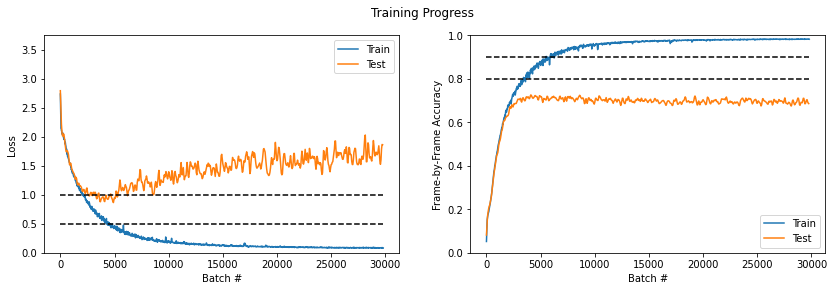

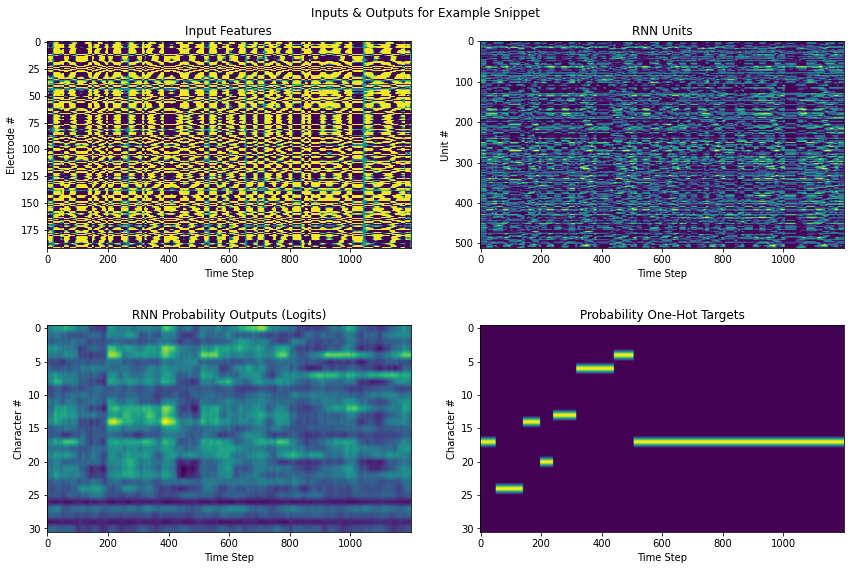

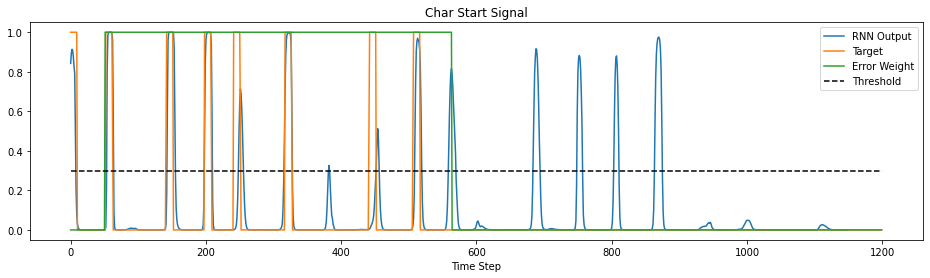

In [ ]:
#Run this cell to visualize the training process in real-time. You can stop it at any time without interrupting the
#training.
import time
from IPython import display
from scipy.ndimage.filters import gaussian_filter1d

while True:
    #The RNN training process periodically saves off performance statistics and a snapshot of RNN outputs, which we load here.
    try:
        snapshot = scipy.io.loadmat(args['outputDir'] + '/outputSnapshot.mat')
        intOut = scipy.io.loadmat(args['outputDir'] + '/intermediateOutput.mat')
    except:
        time.sleep(30)
        continue
    
    display.clear_output(wait=True)

    plotEnd = np.argwhere(intOut['batchTrainStats'][:,0]==0)
    plotEnd = plotEnd[1][0]-1
    
    plotEndVal = np.argwhere(intOut['batchValStats'][:,0]==0)
    plotEndVal = plotEndVal[1][0]-1
    
    #----Training loss & frame-by-frame accuracy----
    plt.figure(figsize=(14,4))
    plt.subplot(1,2,1)
    plt.plot(intOut['batchTrainStats'][0:plotEnd,0], gaussian_filter1d(intOut['batchTrainStats'][0:plotEnd,1], 10))
    plt.plot(intOut['batchValStats'][0:plotEndVal,0], gaussian_filter1d(intOut['batchValStats'][0:plotEndVal,1], 1))
    plt.plot([0, intOut['batchValStats'][plotEndVal,0]], [0.50, 0.50],'--k') #guidelines for visualization
    plt.plot([0, intOut['batchValStats'][plotEndVal,0]], [1.0, 1.0],'--k')
    plt.xlabel('Batch #')
    plt.legend(['Train','Test'])
    plt.ylim([0,3.75])
    plt.ylabel('Loss')
    
    plt.subplot(1,2,2)
    plt.plot(intOut['batchTrainStats'][0:plotEnd,0], gaussian_filter1d(intOut['batchTrainStats'][0:plotEnd,3], 10))
    plt.plot(intOut['batchValStats'][0:plotEndVal,0], gaussian_filter1d(intOut['batchValStats'][0:plotEndVal,3], 1))
    plt.plot([0, intOut['batchValStats'][plotEndVal,0]], [0.8, 0.8],'--k') #guidelines for visualization
    plt.plot([0, intOut['batchValStats'][plotEndVal,0]], [0.9, 0.9],'--k')
    plt.ylim([0,1.0])
    plt.xlabel('Batch #')
    plt.legend(['Train','Test'])
    plt.ylabel('Frame-by-Frame Accuracy')
    
    plt.suptitle('Training Progress')

    display.display(plt.gcf())
    plt.close()
        
    #----RNN outputs & training targets----
    plt.figure(figsize=(12.45, 8.3))
    plt.subplot(2,2,1)
    plt.imshow(np.transpose(snapshot['inputs']),aspect='auto',clim=[-1,1])
    plt.title('Input Features')
    plt.ylabel('Electrode #')
    plt.xlabel('Time Step')

    plt.subplot(2,2,2)
    plt.imshow(np.transpose(snapshot['rnnUnits']),aspect='auto',clim=[-1,1])
    plt.title('RNN Units')
    plt.ylabel('Unit #')
    plt.xlabel('Time Step')

    plt.subplot(2,2,3)
    plt.imshow(np.transpose(snapshot['charProbOutput']),aspect='auto')
    plt.title('RNN Probability Outputs (Logits)')
    plt.ylabel('Character #')
    plt.xlabel('Time Step')

    plt.subplot(2,2,4)
    plt.imshow(np.transpose(snapshot['charProbTarget']),aspect='auto')
    plt.title('Probability One-Hot Targets')
    
    
    plt.ylabel('Character #')
    plt.xlabel('Time Step')

    
    plt.tight_layout(pad=3)
    plt.suptitle('Inputs & Outputs for Example Snippet')
    display.display(plt.gcf())
    plt.close()

    plt.figure(figsize=(16,4))
    plt.plot(np.squeeze(snapshot['charStartOutput']))
    plt.plot(np.squeeze(snapshot['charStartTarget']))
    plt.plot(np.squeeze(snapshot['errorWeight']))
    plt.plot([0,snapshot['errorWeight'].shape[1]],[0.3,0.3],'--k')
    plt.title('Char Start Signal')
    plt.xlabel('Time Step')
    plt.legend(['RNN Output','Target','Error Weight','Threshold'])
    
    display.display(plt.gcf())
    plt.close()
    
    time.sleep(30)